In [1]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
infile = 'sample_data_segments.csv'
df = pd.read_csv(infile)

In [3]:
df.head(5)

,user,expid,click,like,age,gender,friend_cnt,sns_like_cnt,sns_comment_cnt
0,58908,1,0,0,35,2,740,123,176
1,41905,0,0,0,25,2,180,32,97
2,73087,0,0,0,28,1,692,214,205
3,4122,1,0,0,25,2,528,26,569
4,53139,1,0,0,26,1,694,40,102


In [3]:
def get_gender(gender):
    if gender == 1:
        gender_x = 'male'
    else:
        gender_x = 'female'
    return gender_x

Construct Age Groups:

In [4]:
def get_age(age):
    if age <= 20:
        age_x = '1_20'
    elif age <= 30:
        age_x = '21_30'
    elif age <= 40:
        age_x = '31_40'
    else:
        age_x = '40+'
    return age_x

In [5]:
age_level = df.age.apply(get_age).rename('age_level')
gender_level = df.gender.apply(get_gender).rename('gender_level')
df = pd.concat([df, age_level, gender_level], axis = 1)

In [6]:
df

,user,expid,click,like,age,gender,friend_cnt,sns_like_cnt,sns_comment_cnt,age_level,gender_level
0,58908,1,0,0,35,2,740,123,176,31_40,female
1,41905,0,0,0,25,2,180,32,97,21_30,female
2,73087,0,0,0,28,1,692,214,205,21_30,male
3,4122,1,0,0,25,2,528,26,569,21_30,female
4,53139,1,0,0,26,1,694,40,102,21_30,male
...,...,...,...,...,...,...,...,...,...,...,...
99995,85674,0,0,0,33,2,233,88,460,31_40,female
99996,27014,1,0,0,30,1,203,32,79,21_30,male
99997,67693,1,0,0,32,1,116,10,67,31_40,male
99998,8138,1,0,0,22,2,540,176,356,21_30,female


In [9]:
df.head(5)

,user,expid,click,like,age,gender,friend_cnt,sns_like_cnt,sns_comment_cnt,age_level,gender_level
0,58908,1,0,0,35,2,740,123,176,31_40,female
1,41905,0,0,0,25,2,180,32,97,21_30,female
2,73087,0,0,0,28,1,692,214,205,21_30,male
3,4122,1,0,0,25,2,528,26,569,21_30,female
4,53139,1,0,0,26,1,694,40,102,21_30,male


**Average treatment-effect of click**

In [7]:
#ATE across all the users
d_0 = df[df['expid'] == 0]['click']
d_1 = df[df['expid'] == 1]['click']
diff = np.mean(d_1) - np.mean(d_0)
print(diff)
cm = sms.CompareMeans(sms.DescrStatsW(d_1), sms.DescrStatsW(d_0))
ttest = cm.ttest_ind(alternative = 'two-sided', usevar = 'unequal')
ci=cm.tconfint_diff(alternative = 'two-sided', usevar = 'unequal')
print(ttest,ci)

0.008800000000000002
(7.849010417026995, 4.2352949969904484e-15, 98312.97747114798) (0.0066025388562061405, 0.010997461143793864)


**Treatment Effects with Regression**

In [9]:
mod = smf.ols(formula='click ~ expid', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     61.61
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           4.23e-15
Time:                        21:21:00   Log-Likelihood:                 31115.
No. Observations:              100000   AIC:                        -6.223e+04
Df Residuals:                   99998   BIC:                        -6.221e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0281      0.001     35.445      0.0

**Across genders**

In [11]:
gender_list = ['male', 'female']
gender_res = []
for x in gender_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['gender_level'] == x)]['click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['gender_level'] == x)]['click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    gender_res.append([x, tmp_diff, tmp_ci])
print(gender_res)

[['male', 0.00976033193436894, (0.006116616564402275, 0.013404047304335606)], ['female', 0.007927217459660667, (0.0052684094773919055, 0.01058602544192943)]]


**Plot CATE for males and females** 

[Text(0, 0, 'male'), Text(0, 0, 'female')]

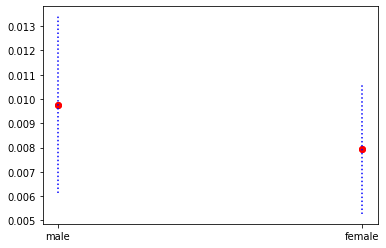

In [14]:
for i in range(len(gender_res)):
    diff = gender_res[i][1]
    ci = gender_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(gender_res)))
f.set_xticklabels(gender_list)

**Across age groups**

In [13]:
age_list = ['1_20', '21_30', '31_40', '40+']
age_res = []
for x in age_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['age_level'] == x)]['click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['age_level'] == x)]['click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    age_res.append([x, tmp_diff, tmp_ci])
print(age_res)

[['1_20', 0.009749430597524082, (0.0028267565803360515, 0.016672104614712115)], ['21_30', 0.005707122483953851, (0.003050012124477334, 0.008364232843430368)], ['31_40', 0.015032703999193618, (0.010335119098819161, 0.019730288899568075)], ['40+', 0.018089733545199715, (0.0005762022474573372, 0.035603264842942094)]]


**Plot CATE for different age groups** 

[Text(0, 0, '1_20'),
 Text(1, 0, '21_30'),
 Text(2, 0, '31_40'),
 Text(3, 0, '40+')]

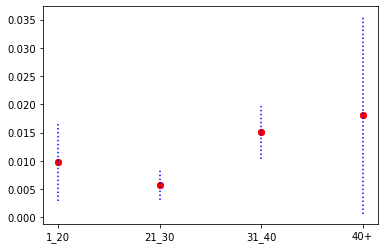

In [14]:
for i in range(len(age_res)):
    diff = age_res[i][1]
    ci = age_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(age_res)))
f.set_xticklabels(age_list)

### Compare CATE between Genders & Impacts of Gender on Treatment Effects with OLS + Interaction Term 

In [19]:
#Transform gender into dummies
df.gender=df.gender-1

In [20]:
df.head(5)

,user,expid,click,like,age,gender,friend_cnt,sns_like_cnt,sns_comment_cnt,age_level,gender_level
0,58908,1,0,0,35,1,740,123,176,31_40,female
1,41905,0,0,0,25,1,180,32,97,21_30,female
2,73087,0,0,0,28,0,692,214,205,21_30,male
3,4122,1,0,0,25,1,528,26,569,21_30,female
4,53139,1,0,0,26,0,694,40,102,21_30,male


In [21]:
import statsmodels.formula.api as smf

In [22]:
mod_gender = smf.ols(formula='click ~ gender + expid + gender*expid', data=df)

In [23]:
res_gender = mod_gender.fit()

In [24]:
print(res_gender.summary())

                            OLS Regression Results                            
Dep. Variable:                  click   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     75.09
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.66e-48
Time:                        21:27:42   Log-Likelihood:                 31196.
No. Observations:              100000   AIC:                        -6.238e+04
Df Residuals:                   99996   BIC:                        -6.235e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0355      0.001     29.992   

### Impacts of Age on Treatment Effects with OLS + Interaction Term

In [24]:
# Age is a continous variance - test how age impact the treatment effects
mod_age = smf.ols(formula='click ~ age + expid + age*expid', data=df)

In [31]:
res_age = mod_age.fit()

In [32]:
print(res_age.summary())

                            OLS Regression Results                            
Dep. Variable:                  click   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     61.14
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           1.75e-39
Time:                        20:55:54   Log-Likelihood:                 31176.
No. Observations:              100000   AIC:                        -6.234e+04
Df Residuals:                   99996   BIC:                        -6.231e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0064      0.004      1.595      0.1